# Emotion Detection from text using NLP

In [67]:
import json
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt


In [2]:
df = pd.read_json("nlp_train.json")

In [3]:
df = df.transpose()

In [128]:
df.head()

,body,subreddit,created_utc,author,link_id,parent_id,emotion,complete
0,answering question criticism individual referr...,worldnews,1584474347,lostdoty13,t3_fkb1jo,t1_fkrog8a,"{'anger': True, 'anticipation': False, 'disgus...",True
1,going start today discussion thread personal o...,CoronavirusCA,1583695737,ErikCavey,t3_ffhe1g,t3_ffhe1g,"{'anger': True, 'anticipation': True, 'disgust...",False
2,announcing self quarantined paints picture ma...,Coronavirus,1582324871,jimkurth81,t3_f76ab0,t1_fiaxs2j,"{'anger': True, 'anticipation': True, 'disgust...",False
3,likewise sorry offended actually immunocomprom...,China_Flu,1583140191,DickGrimes79,t3_fc8ar8,t1_fj9aaqt,"{'anger': True, 'anticipation': False, 'disgus...",False
4,people infected experience high fever cough sh...,worldnews,1583741759,Fresherty,t3_ffebea,t1_fjzd331,"{'anger': False, 'anticipation': False, 'disgu...",False


## Text Preprocessing

In [4]:
import re
from nltk.corpus import stopwords
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-zA-Z#+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
    Clean text by removing stopwords and unwanted symbols.
    """
    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub(' ', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df['body'] = df['body'].apply(clean_text)
df['body'] = df['body'].str.replace('\d+', '')

In [129]:
df['emotion']

0       {'anger': True, 'anticipation': False, 'disgus...
1       {'anger': True, 'anticipation': True, 'disgust...
2       {'anger': True, 'anticipation': True, 'disgust...
3       {'anger': True, 'anticipation': False, 'disgus...
4       {'anger': False, 'anticipation': False, 'disgu...
                              ...                        
1488    {'anger': True, 'anticipation': False, 'disgus...
1489    {'anger': True, 'anticipation': False, 'disgus...
1490    {'anger': False, 'anticipation': True, 'disgus...
1491    {'anger': False, 'anticipation': True, 'disgus...
1492    {'anger': False, 'anticipation': False, 'disgu...
Name: emotion, Length: 1493, dtype: object

#### Lets parse the emotion field as it is in its own JSON form

In [130]:
from collections import defaultdict
y = defaultdict(list)
for i, post in enumerate(df['emotion']):
    for emotion in post:
        if df['emotion'][i][emotion]:
            y[emotion].append(1)
        else:
            y[emotion].append(0)

In [131]:
labels = pd.DataFrame(y)

In [132]:
labels

,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust,neutral
0,1,0,1,0,0,0,0,1,0,0,0,0
1,1,1,1,1,0,0,0,1,0,0,0,0
2,1,1,1,1,0,0,0,1,0,0,0,0
3,1,0,1,1,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1488,1,0,1,1,0,0,0,1,1,0,0,0
1489,1,0,1,1,0,0,0,0,1,0,0,0
1490,0,1,0,1,0,0,1,0,0,0,1,0
1491,0,1,0,1,0,0,0,0,1,0,0,0


### Tokenizing input text

In [49]:
from keras.preprocessing.text import Tokenizer

# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each post
MAX_SEQUENCE_LENGTH = 100

EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['body'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 28327 unique tokens.


In [50]:
from keras.preprocessing.sequence import pad_sequences
X = tokenizer.texts_to_sequences(df['body'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data:', X.shape)

Shape of data: (1493, 400)


In [51]:
y = labels.values
print('Shape of labels:', y.shape)

Shape of labels: (1493, 12)


In [52]:
#subreddits = pd.get_dummies(df["subreddit"]).values

In [53]:
#X = np.concatenate((X, subreddits), axis=1)

TRAIN-TEST SPLIT

In [54]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.10, random_state = 42)

### The LSTM model

In [55]:
from keras import Sequential
from keras.layers import LSTM, Dense, Embedding, SpatialDropout1D
from keras.callbacks import EarlyStopping
from keras.losses import KLD

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(150, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(12, activation='sigmoid'))
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])

epochs = 25
batch_size = 64

history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.15,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 1141 samples, validate on 202 samples
Epoch 1/25
1141/1141 [==============================] - 21s 18ms/step - loss: 0.6295 - acc: 0.6784 - val_loss: 0.5421 - val_acc: 0.7059
Epoch 2/25
1141/1141 [==============================] - 18s 15ms/step - loss: 0.5445 - acc: 0.7087 - val_loss: 0.5407 - val_acc: 0.7083
Epoch 3/25
1141/1141 [==============================] - 18s 16ms/step - loss: 0.5399 - acc: 0.7176 - val_loss: 0.5390 - val_acc: 0.7092
Epoch 4/25
1141/1141 [==============================] - 18s 16ms/step - loss: 0.5365 - acc: 0.7236 - val_loss: 0.5385 - val_acc: 0.7042
Epoch 5/25
1141/1141 [==============================] - 18s 16ms/step - loss: 0.5301 - acc: 0.7317 - val_loss: 0.5348 - val_acc: 0.7104
Epoch 6/25
1141/1141 [==============================] - 18s 15ms/step - loss: 0.5116 - acc: 0.7565 - val_loss: 0.5241 - val_acc: 0.7252
Epoch 7/25
1141/1141 [==============================] - 19s 17ms/step - loss: 0.4718 - acc: 0.7843 - val_loss: 0.5256 - val_acc: 0.7281
E

In [127]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 400, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_7 (Spatial (None, 400, 100)          0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 150)               150600    
_________________________________________________________________
dense_7 (Dense)              (None, 12)                1812      
Total params: 5,152,412
Trainable params: 5,152,412
Non-trainable params: 0
_________________________________________________________________


In [56]:
accr = model.evaluate(x_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

150/150 [==============================] - 1s 5ms/step
Test set
  Loss: 0.556
  Accuracy: 0.749


#### Test Accuracy = 74.9%

## Prediction from given text and plotting probabilities

In [112]:
def prediction_graph(preds):
    """
    draw the graph of prediction probabilities
    """
    plt.rcdefaults()
    fig, ax = plt.subplots()
    
    emotions = list(labels.columns)
    y_pos = np.arange(len(emotions))

    ax.barh(y_pos, preds[0], align='center')
    ax.plot([0.5]*14,np.arange(-1,13), 'g--')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(emotions)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Probability')
    ax.set_title('Emotion Prediction')

    plt.show()


def give_prediction_from_text(text):
    """
    Helper function for giving prediction from text directly
    """
    text = clean_text(text)
    testcase = tokenizer.texts_to_sequences([text])
    testcase = pad_sequences(testcase, maxlen=MAX_SEQUENCE_LENGTH)
    predictions = model.predict(testcase)
    prediction_graph(predictions)

In [114]:
text = "Likewise, sorry if I offended you. I’m not actually immunocompromised, \
but my lungs have collapsed several times due to pneumonia. I didn’t mean to get \
defensive, it’s just that during this corona crisis I’ve had so many people say that \
people who panic or are afraid are ridiculous, alarmist, paranoid, weak-willed, \
fear-mongerers or - my personal favorite - fascists. You get sick of people telling \
you to relax and stop worrying. Without worrying, I’d be dead.\n\nI know you meant well. \
Fear is not ideal. But life never is. You play with the hand you are dealt.\n\nPeace."

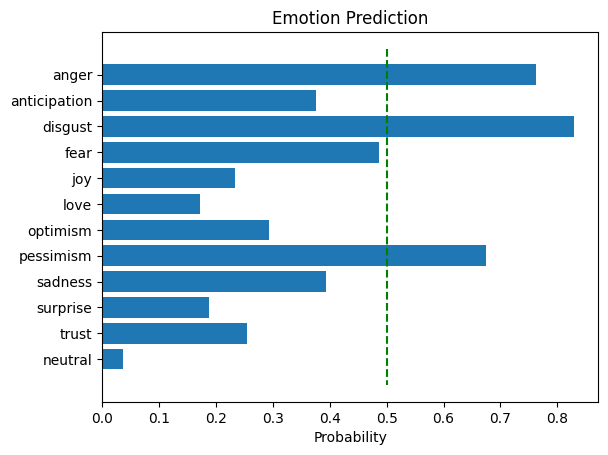

In [119]:
give_prediction_from_text(text)

Very close to the real labels, (Anger, Disgust, Fear, Pessimism) 

The main drawback of the model is shown below. For small texts, it isn't able to give strong prediction for any emotion.

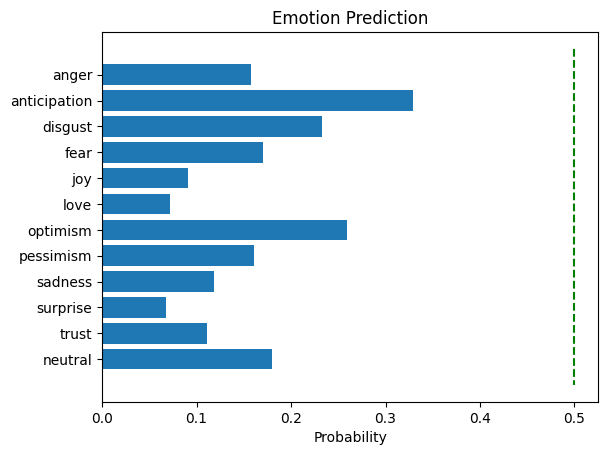

In [126]:
give_prediction_from_text("i love you very much. More than you love me. Thats for sure")